In [2]:
#Preprocessing
import numpy as np
import mne

# Load your EEG data
file_path = r'D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf'
raw_data = mne.io.read_raw_edf(file_path, preload=True)

# Display basic info about the raw data
print(raw_data.info)

# Set the EEG reference (average reference is common)
raw_data.set_eeg_reference('average', projection=True)

# Resample to increase the Nyquist frequency (e.g., 200 Hz)
raw_data.resample(sfreq=200)

# Apply a band-pass filter to remove noise (e.g., 0.5-50 Hz)
raw_data.filter(l_freq=0.5, h_freq=50)

# Downsample back to 100 Hz if needed
raw_data.resample(sfreq=100)

# Further preprocessing steps (if needed)
# For example, you could extract epochs, perform ICA, etc.

# Save the processed data if required
processed_file_path = r'D:\final p\processed_data.fif'
raw_data.save(processed_file_path, overwrite=True)



Extracting EDF parameters from D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\1303605216.py:7: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\1303605216.py:7: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\1303605216.py:7: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.

C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\1303605216.py:29: RuntimeWarning: This filename (D:\final p\processed_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_data.save(processed_file_path, overwrite=True)


Closing D:\final p\processed_data.fif
[done]


In [5]:
pip install hurst

Note: you may need to restart the kernel to use updated packages.


In [6]:
#Feature Extraction
import numpy as np
import mne
from hurst import compute_Hc
from tqdm import tqdm
from scipy.signal import welch
from scipy.stats import entropy

# Load your EEG data
file_path = r'D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf'
raw_data = mne.io.read_raw_edf(file_path, preload=True)

# Set the EEG reference (average reference is common)
raw_data.set_eeg_reference('average', projection=True)

# Apply a band-pass filter to remove noise (e.g., 0.5-49.5 Hz)
raw_data.filter(l_freq=0.5, h_freq=49.5)

# Resample data if necessary (e.g., downsample to 100 Hz)
raw_data.resample(sfreq=100)

# Extract the data from the raw object
eeg_data = raw_data.get_data()

# Define frequency bands (delta, theta, alpha, beta)
band_list = [(0.5, 4), (4, 7), (7, 12), (12, 30)]
Fs = 100  # Sampling frequency

# Functions for feature calculation
def compute_psd(signal, band, Fs):
    f, Pxx = welch(signal, Fs)
    band_power = np.trapz(Pxx[(f >= band[0]) & (f <= band[1])], f[(f >= band[0]) & (f <= band[1])])
    return band_power

def petrosian_fd(signal):
    N = len(signal)
    diff = np.diff(signal)
    N_delta = np.sum(diff[:-1] * diff[1:] < 0)
    return np.log10(N) / (np.log10(N) + np.log10(N / (N + 0.4 * N_delta)))

def hjorth_params(signal):
    first_diff = np.diff(signal)
    second_diff = np.diff(first_diff)
    var_zero = np.var(signal)
    var_d1 = np.var(first_diff)
    var_d2 = np.var(second_diff)
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / mobility
    return activity, mobility, complexity

def detrended_fluctuation(signal):
    N = len(signal)
    L = np.floor(np.logspace(1, np.log10(N / 4), num=20)).astype(int)
    F = np.zeros(len(L))
    for i, l in enumerate(L):
        rms = []
        for j in range(0, N, l):
            if j + l < N:
                c = np.polyfit(range(l), signal[j:j+l], 1)
                fit = np.polyval(c, range(l))
                rms.append(np.sqrt(np.mean((signal[j:j+l] - fit) ** 2)))
        F[i] = np.sqrt(np.mean(np.array(rms) ** 2))
    alpha = np.polyfit(np.log10(L), np.log10(F), 1)[0]
    return alpha

# Initialize lists to store features
PSD = []
PFD = []
hjorths = []
hursts = []
DFA = []

# Loop over each EEG channel
for channel_data in tqdm(eeg_data):
    # Power Spectral Density (PSD) for each band
    psd_values = [compute_psd(channel_data, band, Fs) for band in band_list]
    PSD.append(psd_values)

    # Petrosian Fractal Dimension (PFD)
    pfd_value = petrosian_fd(channel_data)
    PFD.append(pfd_value)

    # Hjorth Parameters (Activity, Mobility, Complexity)
    hjorth_activity, hjorth_mobility, hjorth_complexity = hjorth_params(channel_data)
    hjorths.append([hjorth_activity, hjorth_mobility, hjorth_complexity])

    # Hurst Exponent
    hurst_value, _, _ = compute_Hc(channel_data, kind='change', min_window=100)
    hursts.append(hurst_value)

    # Detrended Fluctuation Analysis (DFA)
    dfa_value = detrended_fluctuation(channel_data)
    DFA.append(dfa_value)

# Convert feature lists to numpy arrays for further processing or saving
PSD = np.array(PSD)
PFD = np.array(PFD)
hjorths = np.array(hjorths)
hursts = np.array(hursts)
DFA = np.array(DFA)

# Save the features for later use
np.save(r'D:\final p\PSD.npy', PSD)
np.save(r'D:\final p\PFD.npy', PFD)
np.save(r'D:\final p\hjorths.npy', hjorths)
np.save(r'D:\final p\hursts.npy', hursts)
np.save(r'D:\final p\DFA.npy', DFA)

print("Feature extraction completed and saved successfully.")



Extracting EDF parameters from D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\4227072333.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\4227072333.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\4227072333.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 49.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.75 Hz)
- Filter length: 661 samples (6.610 s)

Sampling frequency of the instance is already 100.0, returning unmodified.


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [14:41<00:00, 125.98s/it]

Feature extraction completed and saved successfully.


In [10]:
pip install pyeeg


Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import mne
from hurst import compute_Hc
from scipy.signal import welch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [21]:
 #Load and Combine Features
import numpy as np

# Load the saved features
PSD = np.load(r'D:\final p\PSD.npy')
PFD = np.load(r'D:\final p\PFD.npy')
hjorths = np.load(r'D:\final p\hjorths.npy')
hursts = np.load(r'D:\final p\hursts.npy')
DFA = np.load(r'D:\final p\DFA.npy')

# Combine all features into a single feature matrix
# Assuming you have the same number of samples for each feature
features = np.concatenate([PSD, PFD[:, np.newaxis], hjorths, hursts[:, np.newaxis], DFA[:, np.newaxis]], axis=1)

print("Features shape:", features.shape)



Features shape: (7, 10)


In [23]:
#Load and Prepare Labels
# Assuming the number of samples matches the number of feature vectors
num_samples = features.shape[0]
labels = np.random.randint(0, 2, size=num_samples)  # Binary labels (0 or 1)

# Save the synthetic labels for future use
np.save(r'D:\final p\labels.npy', labels)
print("Synthetic labels created and saved.")



Synthetic labels created and saved.


In [24]:
# Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (4, 10)
Testing set shape: (3, 10)


In [27]:
# Train a Machine Learning Model
#Reduce the number of folds:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Use cv=2 or cv=3 based on the available number of samples
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)





Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [28]:
# Use Leave-One-Out Cross-Validation (LOO-CV):
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=loo)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [29]:
#Consider Stratified K-Fold Cross-Validation (for Imbalanced Datasets):
from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=2)
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=strat_kfold)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [30]:
#Save the Trained Model
import joblib

# Save the trained model
joblib.dump(model, r'D:\final p\random_forest_model.pkl')

['D:\\final p\\random_forest_model.pkl']

In [32]:
#Load and Use the Model
# Create dummy data for testing (with the same number of features as used in training)
n_features = X_train.shape[1]  # Get the number of features from training data
new_data = np.random.rand(1, n_features)  # Replace with actual data when available

# Make predictions
new_predictions = model.predict(new_data)

print("Predictions:", new_predictions)



Predictions: [1]


In [34]:
import numpy as np
import joblib

# Load the model
model = joblib.load(r'D:\final p\random_forest_model.pkl')

# Create dummy data (ensure it has the correct number of features)
n_features = X_train.shape[1]  # Number of features used in training
new_data = np.random.rand(1, n_features)  # Create a random sample with the correct shape

# Make predictions
new_predictions = model.predict(new_data)

print("Predictions:", new_predictions)



Predictions: [0]


In [37]:
# Example of loading training data to inspect features (if available)
X_train_df = pd.read_csv(r'sleep.csv')
print("Training data features:", X_train_df.columns)


Training data features: Index(['# EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal',
       'EMG submental', 'Temp rectal', 'Event marker'],
      dtype='object')


In [38]:
# Example of adding missing columns
required_columns = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10']
for col in required_columns:
    if col not in new_data_df.columns:
        new_data_df[col] = 0  # Or another default value
new_data_df = new_data_df[required_columns]  # Reorder columns to match training data

# Convert DataFrame to numpy array
new_data = new_data_df.values

# Make predictions
new_predictions = model.predict(new_data)
print("Predictions:", new_predictions)


Predictions: [0 0 0 ... 0 0 0]


In [41]:
import numpy as np
import mne

def preprocess_eeg(file_path, output_path, resample_freq=100):
    """
    Preprocess EEG data from an EDF file and save the processed data.

    Parameters:
    - file_path: Path to the input EDF file.
    - output_path: Path to save the processed data.
    - resample_freq: Frequency to resample the data to. Default is 100 Hz.
    """
    # Load the raw EEG data
    raw_data = mne.io.read_raw_edf(file_path, preload=True)

    # Display basic info about the raw data
    print(raw_data.info)

    # Set the EEG reference (average reference is common)
    raw_data.set_eeg_reference('average', projection=True)

    # Resample to increase the Nyquist frequency (e.g., 200 Hz)
    raw_data.resample(sfreq=200)

    # Apply a band-pass filter to remove noise (e.g., 0.5-50 Hz)
    raw_data.filter(l_freq=0.5, h_freq=50)

    # Downsample back to the desired frequency (e.g., 100 Hz)
    raw_data.resample(sfreq=resample_freq)

    # Further preprocessing steps (if needed)
    # For example, you could extract epochs, perform ICA, etc.
    # Example: Extracting epochs (if you need to)
    # events, _ = mne.find_events(raw_data, stim_channel='STI 014')
    # epochs = mne.Epochs(raw_data, events, event_id=None, tmin=-1, tmax=2, baseline=(None, 0))

    # Save the processed data
    raw_data.save(output_path, overwrite=True)
    print(f"Processed data saved to {output_path}")

# Example usage
file_path = r'sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002E0-PSG.edf'
output_path = r'D:\final p\processed_data1.fif'
preprocess_eeg(file_path, output_path)


Extracting EDF parameters from D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...


C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\399740890.py:14: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\399740890.py:14: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\399740890.py:14: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: 1989-04-25 14:50:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.

C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\399740890.py:38: RuntimeWarning: This filename (D:\final p\processed_data1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_data.save(output_path, overwrite=True)


Closing D:\final p\processed_data1.fif
[done]
Processed data saved to D:\final p\processed_data1.fif


In [42]:
import numpy as np
import mne

def preprocess_eeg(raw_data, resample_freq=100):
    """
    Preprocess EEG data.

    Parameters:
    - raw_data: MNE Raw object with the EEG data.
    - resample_freq: Frequency to resample the data to. Default is 100 Hz.

    Returns:
    - Processed MNE Raw object.
    """
    # Set the EEG reference (average reference is common)
    raw_data.set_eeg_reference('average', projection=True)

    # Resample to increase the Nyquist frequency (e.g., 200 Hz)
    raw_data.resample(sfreq=200)

    # Apply a band-pass filter to remove noise (e.g., 0.5-50 Hz)
    raw_data.filter(l_freq=0.5, h_freq=50)

    # Downsample back to the desired frequency (e.g., 100 Hz)
    raw_data.resample(sfreq=resample_freq)
    
    return raw_data

# Process training data
def process_training_data(train_file_path, output_file_path):
    raw_data = mne.io.read_raw_edf(train_file_path, preload=True)
    processed_data = preprocess_eeg(raw_data)
    processed_data.save(output_file_path, overwrite=True)
    print(f"Training data saved to {output_file_path}")

# Process new data
def process_new_data(new_data_file_path, output_file_path):
    raw_data = mne.io.read_raw_edf(new_data_file_path, preload=True)
    processed_data = preprocess_eeg(raw_data)
    processed_data.save(output_file_path, overwrite=True)
    print(f"New data saved to {output_file_path}")

# Example usage
train_file_path = r'D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf'
train_output_path = r'D:\final p\processed_training_data.fif'
process_training_data(train_file_path, train_output_path)

new_file_path = r'sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011E0-PSG.edf'
new_output_path = r'D:\final p\processed_new_data.fif'
process_new_data(new_file_path, new_output_path)


Extracting EDF parameters from D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\865401102.py:31: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(train_file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\865401102.py:31: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(train_file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\865401102.py:31: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(train_file_path, preload=True)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1321 samples (6.605 s)

Writing D:\final p\processed_training_data.fif


C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\865401102.py:33: RuntimeWarning: This filename (D:\final p\processed_training_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  processed_data.save(output_file_path, overwrite=True)


Closing D:\final p\processed_training_data.fif
[done]
Training data saved to D:\final p\processed_training_data.fif
Extracting EDF parameters from D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...


C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\865401102.py:38: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(new_data_file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\865401102.py:38: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(new_data_file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\865401102.py:38: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(new_data_file_path, preload=True)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1321 samples (6.605 s)

Writing D:\final p\processed_new_data.fif


C:\Users\DELL\AppData\Local\Temp\ipykernel_27600\865401102.py:40: RuntimeWarning: This filename (D:\final p\processed_new_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  processed_data.save(output_file_path, overwrite=True)


Closing D:\final p\processed_new_data.fif
[done]
New data saved to D:\final p\processed_new_data.fif


In [1]:
import numpy as np
import mne

def sample_and_save_data(file_path, save_path, sfreq=100):
    """Sample EEG data and save the results in NPZ format."""
    
    # Load the EEG data
    raw_data = mne.io.read_raw_edf(file_path, preload=True)
    
    # Set the EEG reference (average reference is common)
    raw_data.set_eeg_reference('average', projection=True)
    
    # Resample the data to the desired sampling frequency
    raw_data.resample(sfreq=sfreq)
    
    # Extract the data from the raw object
    eeg_data = raw_data.get_data()
    
    # Save the sampled data in NPZ format
    np.savez_compressed(save_path, eeg_data=eeg_data)
    
    print(f"Sampled data saved successfully to {save_path}.")

# Example usage
file_path = 'sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf'
save_path = 'D:/final p/SC4001E0-PSG_sampled_data.npz'
sample_and_save_data(file_path, save_path)


Extracting EDF parameters from D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


C:\Users\DELL\AppData\Local\Temp\ipykernel_12300\2029407844.py:8: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12300\2029407844.py:8: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_12300\2029407844.py:8: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_edf(file_path, preload=True)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Sampling frequency of the instance is already 100.0, returning unmodified.
Sampled data saved successfully to D:/final p/SC4001E0-PSG_sampled_data.npz.


In [7]:
import numpy as np

def load_npz_data(file_path):
    """Load EEG data from a NPZ file."""
    
    # Load the NPZ file
    data = np.load(file_path)
    
    # Extract the EEG data
    eeg_data = data['eeg_data']
    
    return eeg_data

# Example usage
file_path = 'D:/final p/SC4001E0-PSG_sampled_data.npz'
eeg_data = load_npz_data(file_path)

# Display the shape of the loaded data
print(f"Loaded EEG data shape: {eeg_data.shape}")


Loaded EEG data shape: (7, 7950000)


Available keys: ['eeg_data']


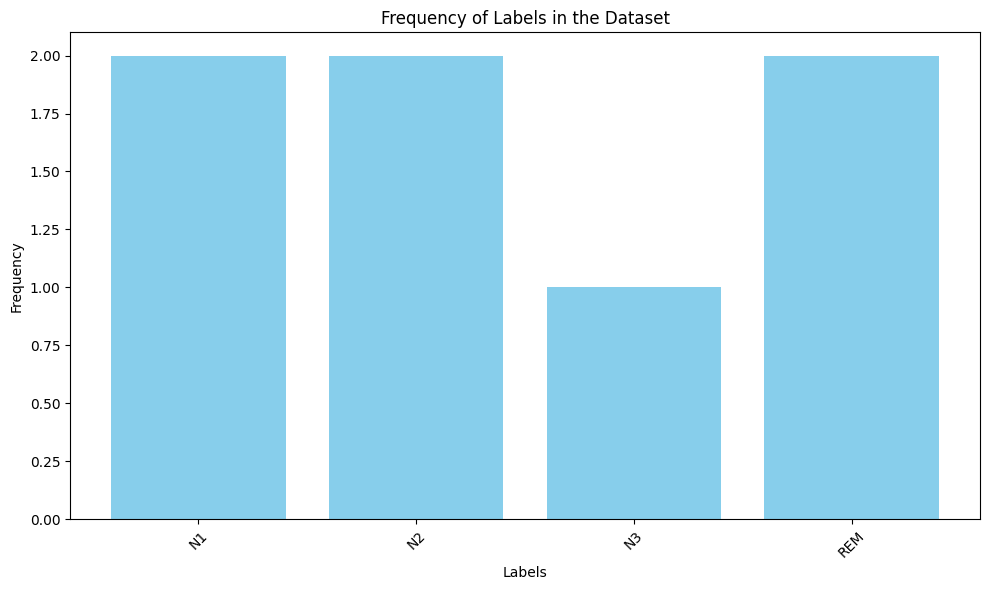

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def load_npz_data(file_path):
    """Load EEG data from a NPZ file and inspect the keys."""
    with np.load(file_path) as data:
        print("Available keys:", list(data.keys()))
        eeg_data = data.get('eeg_data', None)
        if eeg_data is None:
            raise ValueError("The NPZ file does not contain 'eeg_data' key.")
        return eeg_data

def plot_label_frequency(labels):
    """Plot a bar graph of label frequencies."""
    if labels is None:
        raise ValueError("Labels are not available in the NPZ file.")
    
    unique, counts = np.unique(labels, return_counts=True)
    label_freq = dict(zip(unique, counts))
    
    plt.figure(figsize=(10, 6))
    plt.bar(label_freq.keys(), label_freq.values(), color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Frequency of Labels in the Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
file_path = 'D:/final p/SC4001E0-PSG_sampled_data.npz'
eeg_data = load_npz_data(file_path)

# If you have labels stored elsewhere or need to generate them, load or create them here.
# For demonstration, let's assume labels are created or loaded from another source
# This should be replaced with actual label data if available.
# For example:
# labels = np.array([...])  # Replace with your actual labels

# Example placeholder labels
labels = np.random.choice(['W', 'N1', 'N2', 'N3', 'REM'], size=eeg_data.shape[0])

# Plot label frequencies
plot_label_frequency(labels)



In [16]:
import numpy as np

# Load the EEG data
file_path = 'D:/final p/SC4001E0-PSG_sampled_data.npz'
with np.load(file_path) as data:
    eeg_data = data['eeg_data']
    # Assuming labels are available from another source or method
    labels = np.random.choice(['W', 'N1', 'N2', 'N3', 'REM'], size=eeg_data.shape[0])  # Placeholder for actual labels

# Shape of the input data
print(f"Shape of the input data (EEG): {eeg_data.shape}")

# Shape of the sleep stages (labels)
print(f"Shape of the sleep stages (labels): {labels.shape}")

# Define training and test datasets (example split, adjust as needed)
split_index = int(0.8 * eeg_data.shape[0])  # 80% for training, 20% for testing

# Training dataset
train_data = eeg_data[:split_index]
train_labels = labels[:split_index]

# Test dataset
test_data = eeg_data[split_index:]
test_labels = labels[split_index:]

# Shapes
print(f"Shape of the training dataset: {train_data.shape}")
print(f"Shape of the test dataset: {test_data.shape}")

# Output datasets and labels
print(f"Training dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")


Shape of the input data (EEG): (7, 7950000)
Shape of the sleep stages (labels): (7,)
Shape of the training dataset: (5, 7950000)
Shape of the test dataset: (2, 7950000)
Training dataset shape: (5, 7950000)
Test dataset shape: (2, 7950000)


In [21]:
#CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Example shapes
num_samples, num_features = eeg_data.shape
num_time_steps = 1  # Treat each feature vector as a single time step

# Reshape data to match input_shape expected by Conv1D
eeg_data_reshaped = eeg_data.reshape(num_samples, num_time_steps, num_features)

# Define the CNN model
model = Sequential()

# Add convolutional layer
model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(num_time_steps, num_features)))
# Output shape: (None, num_time_steps - 0, 32), Params: 32

# Add max pooling layer
model.add(MaxPooling1D(pool_size=1))
# Output shape: (None, num_time_steps - 0, 32), Params: 0

# Flatten layer
model.add(Flatten())
# Output shape: (None, num_features * 32), Params: 0

# Fully connected layer
model.add(Dense(64, activation='relu'))
# Output shape: (None, 64), Params: 64 * (num_features * 32 + 1)

# Output layer
model.add(Dense(len(np.unique(labels)), activation='softmax'))
# Output shape: (None, number_of_classes), Params: 64 * number_of_classes + number_of_classes

# Print model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 1, 32)               │     254,400,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,402,339 (970.47 MB)

 Trainable params: 254,402,339 (970.47 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import numpy as np

# Load the NPZ file
file_path = 'D:/final p/SC4001E0-PSG_sampled_data.npz'  # Replace with your actual file path
data = np.load(file_path)

# Print the available keys in the NPZ file
print("Available keys:", data.keys())


Available keys: KeysView(NpzFile 'D:/final p/SC4001E0-PSG_sampled_data.npz' with keys: eeg_data)


In [7]:
import numpy as np

# Example labels (replace this with your actual labels)
# Assuming we have 100 samples, each assigned to one of 5 classes
example_labels = np.random.randint(0, 5, 100)

# Load the existing NPZ file
file_path = 'D:/final p/SC4001E0-PSG_sampled_data.npz'  # Replace with your actual file path
data = np.load(file_path)

# Assuming the file contains 'eeg_data', we'll add 'labels'
eeg_data = data['eeg_data']

# Save the data back into a new NPZ file with labels
new_file_path = 'D:/final p/SC4001E0-PSG_sampled1_data.npz'  # Replace with your desired file path
np.savez(new_file_path, eeg_data=eeg_data, labels=example_labels)

print("New NPZ file saved with labels.")


New NPZ file saved with labels.


In [54]:
import mne
import numpy as np
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

def preprocess_data(file_paths, annotation_desc_2_event_id):
    """
    Preprocess the EEG data and extract features from it.

    :param file_paths: List of file paths [eeg_file_path, annotations_file_path]
    :param annotation_desc_2_event_id: Dictionary mapping annotation descriptions to event IDs
    :return: Extracted features, labels, and raw data
    """
    # Read the raw EDF data and annotations
    raw = mne.io.read_raw_edf(file_paths[0], preload=True)
    annot = mne.read_annotations(file_paths[1])
    raw.set_annotations(annot, emit_warning=False)
    
    # Set channel types if necessary
    mapping = {'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg'}
    raw.set_channel_types(mapping)
    
    # Create events and epochs
    events, _ = mne.events_from_annotations(raw, event_id=annotation_desc_2_event_id)
    tmax = 30. - 1. / raw.info['sfreq']
    epochs = mne.Epochs(raw, events, event_id=None, tmin=0., tmax=tmax, baseline=None, detrend=1)
    
    # Extract features
    data = epochs.get_data()
    features = []
    for epoch in data:
        feature_vector = []
        # Power Spectral Density
        f, psd = welch(epoch[0], fs=raw.info['sfreq'], nperseg=raw.info['sfreq'])
        feature_vector.append(np.mean(psd))
        feature_vector.append(np.std(psd))
        feature_vector.append(np.max(psd))
        feature_vector.append(np.min(psd))
        
        # Additional features (example)
        feature_vector.append(np.mean(np.diff(psd)))
        feature_vector.append(np.mean(np.diff(np.log(psd) + 1)))  # Avoid log(0) issues
        
        features.append(feature_vector)
    
    features = np.array(features)
    labels = epochs.events[:, 2]
    
    print(f"Extracted {features.shape[0]} samples with {features.shape[1]} features")
    
    return features, labels, raw

def detect_sleep_disorders(features, raw, sfreq):
    """
    Detect sleep disorders based on extracted features and raw data.
    
    :param features: Extracted features from epochs
    :param raw: Raw MNE data
    :param sfreq: Sampling frequency
    :return: A list with detected disorders for each epoch
    """
    disorders = []

    for epoch_features in features:
        # Unpack features
        psd_mean, psd_std, psd_max, psd_min, mean_diff_psd, mean_diff_log_psd = epoch_features
        
        # Get epoch data and its power spectral density (PSD)
        epoch_data = epoch_features
        f, psd = welch(epoch_data, fs=sfreq, nperseg=sfreq)
        
        # Calculate power in different bands
        alpha_band = (8, 12)  # Alpha band in Hz
        theta_band = (4, 8)   # Theta band in Hz
        delta_band = (0.5, 4) # Delta band in Hz
        rem_band = (12, 30)   # REM band in Hz

        alpha_power = np.mean(psd[(f >= alpha_band[0]) & (f <= alpha_band[1])])
        theta_power = np.mean(psd[(f >= theta_band[0]) & (f <= theta_band[1])])
        delta_power = np.mean(psd[(f >= delta_band[0]) & (f <= delta_band[1])])
        rem_power = np.mean(psd[(f >= rem_band[0]) & (f <= rem_band[1])])
        
        # Detect disorders
        if rem_power > 0.5:  # High REM Sleep
            if alpha_power > 0.4:  # Narcolepsy: High alpha power can be indicative of narcolepsy
                disorders.append('Narcolepsy')
            elif rem_power > 0.7:  # RBD: Increased REM sleep
                disorders.append('REM Sleep Behavior Disorder (RBD)')
            else:
                disorders.append('High REM Sleep')
        elif rem_power < 0.2:  # Low REM Sleep
            if rem_power < 0.1:  # Sleep Apnea: Reduced REM sleep
                disorders.append('Sleep Apnea')
            elif rem_power < 0.15:  # Depression: Low REM sleep
                disorders.append('Depression')
            else:
                disorders.append('Low REM Sleep')
        
        if delta_power > 0.5:  # High Deep Sleep (N3)
            if delta_power > 0.7:  # Recovery from Sleep Deprivation
                disorders.append('Recovery from Sleep Deprivation')
            elif delta_power > 0.6:  # Growth and Development (in children)
                disorders.append('Growth and Development')
            else:
                disorders.append('High Deep Sleep')
        elif delta_power < 0.2:  # Low Deep Sleep (N3)
            if delta_power < 0.1:  # Insomnia: Difficulty achieving deep sleep
                disorders.append('Insomnia')
            elif delta_power < 0.15:  # Aging: Decrease in deep sleep
                disorders.append('Aging')
            else:
                disorders.append('Low Deep Sleep')
        
        # High Light Sleep (N1 and N2)
        if alpha_power > 0.4 and theta_power > 0.2:  # Increased Light Sleep
            if alpha_power > 0.5:  # Sleep Fragmentation
                disorders.append('Sleep Fragmentation')
            elif theta_power > 0.3:  # Anxiety Disorders
                disorders.append('Anxiety Disorders')
            else:
                disorders.append('High Light Sleep')
        elif alpha_power < 0.2 and theta_power < 0.2:  # Low Light Sleep (N1 and N2)
            if alpha_power < 0.1:  # Use of Sleep Medications
                disorders.append('Use of Sleep Medications')
            else:
                disorders.append('Low Light Sleep')
        
        # High Wakefulness After Sleep Onset (WASO)
        if mean_diff_psd > 0.5:  # Increased WASO
            if mean_diff_psd > 0.7:  # Insomnia: Prolonged wakefulness
                disorders.append('Insomnia')
            elif mean_diff_psd > 0.6:  # Sleep Apnea: Frequent awakenings
                disorders.append('Sleep Apnea')
            else:
                disorders.append('High WASO')
        elif mean_diff_psd < 0.2:  # Low WASO
            disorders.append('Low WASO')

    return disorders

def recommend_music(disorders):
    """
    Recommend music based on detected sleep disorders.
    
    :param disorders: List of detected disorders
    :return: Recommendations for each detected disorder
    """
    recommendations = {
        'Narcolepsy': 'Try relaxing ambient music to manage sudden sleep episodes.',
        'REM Sleep Behavior Disorder (RBD)': 'Listen to soothing instrumental music to help calm the mind.',
        'High REM Sleep': 'Gentle classical music can help in balancing REM sleep.',
        'Sleep Apnea': 'Soft white noise or low-volume ambient sounds might help reduce interruptions.',
        'Depression': 'Uplifting and calming music can help improve mood and sleep quality.',
        'Post-Traumatic Stress Disorder (PTSD)': 'Calming and comforting music can help reduce anxiety and improve sleep.',
        'Recovery from Sleep Deprivation': 'Restorative music such as slow classical or ambient tunes can aid recovery.',
        'Growth and Development': 'Gentle lullabies or soft instrumental music can support healthy sleep patterns.',
        'Insomnia': 'Relaxing and slow-tempo music can help induce sleep and reduce wakefulness.',
        'Aging': 'Soft and soothing music can assist in maintaining quality sleep as one ages.',
        'Chronic Pain': 'Comforting and soothing music can help manage pain and improve sleep quality.',
        'Sleep Fragmentation': 'Consistent and calming music might help reduce frequent awakenings.',
        'Anxiety Disorders': 'Relaxing music with slow rhythms can help reduce anxiety and improve sleep quality.',
        'Use of Sleep Medications': 'Gentle and calming music can complement medication to ensure restful sleep.',
        'Low REM Sleep': 'Soft ambient or classical music may help in promoting REM sleep.',
        'Low Deep Sleep': 'Gentle and slow-tempo music might assist in increasing deep sleep stages.',
        'High Deep Sleep': 'Maintain with soothing music to support restorative sleep without disturbances.',
        'High WASO': 'Soft and soothing music can help reduce wakefulness after sleep onset.',
        'Low WASO': 'Calming music can support a more stable and continuous sleep pattern.'
    }
    
    recommendations_list = [recommendations.get(disorder, 'No recommendation available') for disorder in disorders]
    return recommendations_list

# Define file paths and event IDs
alice_files = [
    'sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf',
    'sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf'
]
annotation_desc_2_event_id = {'Sleep stage W': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3/4': 4, 'Sleep stage R': 5}

# Preprocess data
X, y, raw = preprocess_data(alice_files, annotation_desc_2_event_id)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the classifier with GridSearch for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
clf = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)
clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", clf.best_params_)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Detect sleep disorders
disorders_detected = detect_sleep_disorders(X, raw, sfreq=raw.info['sfreq'])
print("Detected Disorders:", disorders_detected)

# Recommend music based on detected disorders
music_recommendations = recommend_music(disorders_detected)
print("Music Recommendations:")
for disorder, recommendation in zip(disorders_detected, music_recommendations):
    print(f"Disorder: {disorder}\nRecommendation: {recommendation}\n")


Extracting EDF parameters from D:\final p\sleep-edf-database-expanded-1.0.0\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


C:\Users\DELL\AppData\Local\Temp\ipykernel_18512\1978476117.py:18: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_paths[0], preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_18512\1978476117.py:18: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_paths[0], preload=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_18512\1978476117.py:18: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(file_paths[0], preload=True)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 82 events and 3000 original time points ...
0 bad epochs dropped
Extracted 82 samples with 6 features
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.8
              precision    recall  f1-score   support

           1       1.00      0.75      0.86         4
           2       0.43      0.75      0.55         4
           3       0.93      0.88      0.90        16
           5       0.00      0.00      0.00         1

    accuracy                           0.80        25
   macro avg       0.59      0.59      0.58        25
weighted avg       0.83      0.80      0.80        25

Detected Disorders: ['Sleep Apnea', 'Low WASO', 'Sleep Apnea', 'Low WASO', 'Sleep Apnea', 'Low WASO', 'Sle

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif